# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools

## DATA PREP

### Initiation Directory

In [2]:
#Path dataset
BASE_DIR = '/kaggle/input/penyakit-paru-paru-5-kelas'

#Path train, test, dan validation
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [3]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16,
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 8,
    shuffle=True
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [18]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet',
                        include_top=False, 
                        input_shape=(224, 224, 3))
for layer in resnet_model.layers:
    layer.trainable = False
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Flatten())
model_resnet.add(Dense(768,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(256,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(train_generator.num_classes, 
                       activation='softmax'))
print(model_resnet.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 768)               77071104  
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               196864    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

In [20]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 93s 236ms/step - loss: 1.6066 - acc: 0.2446 - val_loss: 1.5725 - val_acc: 0.2729
Epoch 2/30
380/380 [==============================] - 88s 232ms/step - loss: 1.5764 - acc: 0.2653 - val_loss: 1.5603 - val_acc: 0.2485
Epoch 3/30
380/380 [==============================] - 88s 232ms/step - loss: 1.5453 - acc: 0.3000 - val_loss: 1.5056 - val_acc: 0.2424
Epoch 4/30
380/380 [==============================] - 89s 234ms/step - loss: 1.5147 - acc: 0.3313 - val_loss: 1.4796 - val_acc: 0.3870
Epoch 5/30
380/380 [==============================] - 88s 231ms/step - loss: 1.4920 - acc: 0.3492 - val_loss: 1.4388 - val_acc: 0.4216
Epoch 6/30
380/380 [==============================] - 88s 232ms/step - loss: 1.4694 - acc: 0.3678 - val_loss: 1.4038 - val_acc: 0.4420
Epoch 7/30
380/380 [==============================] - 88s 230ms/step - loss: 1.4398 - acc: 0.3799 - val_loss: 1.3738 - val_acc: 0.4715
Epoch 8/30
380/380 [==============================] - 8

In [ ]:
#model_resnet.save("resnet_model.h5")
#with open('history_resnet.txt', mode='w') as file:
#    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
#    file.close()

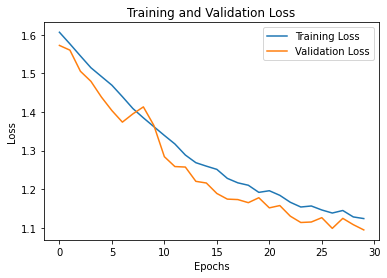

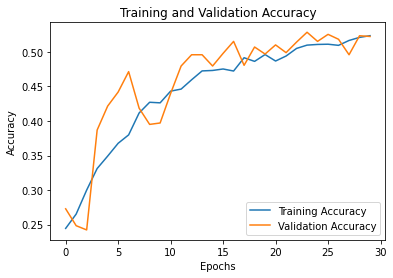

In [21]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 5s 41ms/step - loss: 1.0947 - acc: 0.5224
Loss: 1.0946694612503052
Accuracy: 0.5224032402038574


In [23]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nResNet50 Training classification report:\n", train_class_report)



380/380 [==============================] - 81s 210ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20483   0.32705   0.25189      1220
            covid19    0.21373   0.22043   0.21703      1243
             normal    0.20039   0.16842   0.18302      1235
       tuberculosis    0.20238   0.18889   0.19540      1170
    viral_pneumonia    0.20833   0.12376   0.15528      1212

           accuracy                        0.20592      6080
          macro avg    0.20593   0.20571   0.20052      6080
       weighted avg    0.20597   0.20592   0.20065      6080



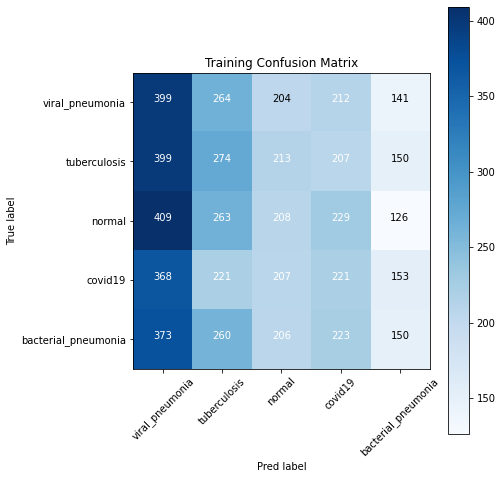

In [24]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("ResNet50 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [5]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = False
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(Flatten())
model_VGG19.add(Dense(768,activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(256,activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 768)               19268352  
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               196864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

In [7]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 165s 405ms/step - loss: 1.2980 - acc: 0.4663 - val_loss: 0.9526 - val_acc: 0.6181
Epoch 2/30
380/380 [==============================] - 105s 276ms/step - loss: 0.9371 - acc: 0.6326 - val_loss: 0.8629 - val_acc: 0.6334
Epoch 3/30
380/380 [==============================] - 105s 276ms/step - loss: 0.8190 - acc: 0.6747 - val_loss: 0.7653 - val_acc: 0.6762
Epoch 4/30
380/380 [==============================] - 105s 275ms/step - loss: 0.7638 - acc: 0.6911 - val_loss: 0.6801 - val_acc: 0.7373
Epoch 5/30
380/380 [==============================] - 104s 273ms/step - loss: 0.7200 - acc: 0.7043 - val_loss: 0.6842 - val_acc: 0.7322
Epoch 6/30
380/380 [==============================] - 102s 269ms/step - loss: 0.6884 - acc: 0.7209 - val_loss: 0.6230 - val_acc: 0.7495
Epoch 7/30
380/380 [==============================] - 101s 267ms/step - loss: 0.6729 - acc: 0.7257 - val_loss: 0.6050 - val_acc: 0.7658
Epoch 8/30
380/380 [============================

In [ ]:
# model_VGG19.save("VGG19_model_skenario1.h5")
# with open('history_VGG19.txt', mode='w') as file:
#    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
#    file.close()

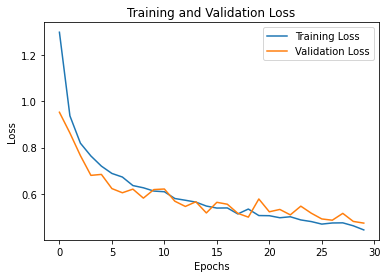

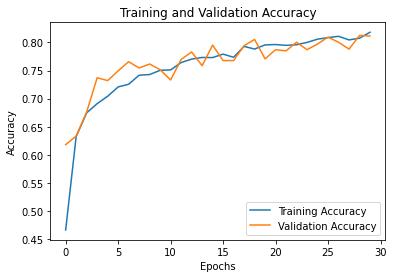

In [9]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG 19 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 8s 61ms/step - loss: 0.4740 - acc: 0.8116
Loss: 0.4739670753479004
Accuracy: 0.8116089701652527


In [11]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nVGG 19 Training classification report:\n", train_class_report)



380/380 [==============================] - 91s 238ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20693   0.18115   0.19318      1220
            covid19    0.20204   0.20676   0.20437      1243
             normal    0.19390   0.20081   0.19730      1235
       tuberculosis    0.19156   0.18632   0.18891      1170
    viral_pneumonia    0.18519   0.20215   0.19329      1212

           accuracy                        0.19556      6080
          macro avg    0.19592   0.19544   0.19541      6080
       weighted avg    0.19599   0.19556   0.19551      6080



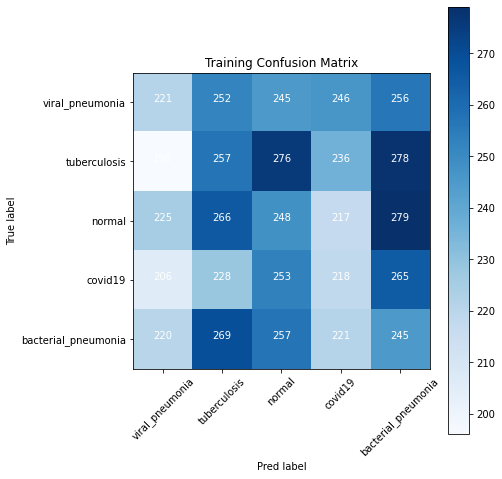

In [12]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("VGG 19 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [13]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = False
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(768,activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(256,activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_InceptionV3.summary())

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 768)               39322368  
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               196864    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_______________________________________________________

In [19]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True
callback = CustomCallback()
# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback,
)

Epoch 1/30
380/380 [==============================] - 109s 274ms/step - loss: 0.7981 - acc: 0.6697 - val_loss: 0.7864 - val_acc: 0.6690
Epoch 2/30
380/380 [==============================] - 101s 266ms/step - loss: 0.6946 - acc: 0.7132 - val_loss: 0.8286 - val_acc: 0.6507
Epoch 3/30
380/380 [==============================] - 101s 267ms/step - loss: 0.6413 - acc: 0.7337 - val_loss: 0.6647 - val_acc: 0.7149
Epoch 4/30
380/380 [==============================] - 101s 265ms/step - loss: 0.6036 - acc: 0.7510 - val_loss: 0.6560 - val_acc: 0.7128
Epoch 5/30
380/380 [==============================] - 100s 263ms/step - loss: 0.5805 - acc: 0.7566 - val_loss: 0.6714 - val_acc: 0.7220
Epoch 6/30
380/380 [==============================] - 101s 265ms/step - loss: 0.5637 - acc: 0.7628 - val_loss: 0.6930 - val_acc: 0.6853
Epoch 7/30
380/380 [==============================] - 101s 267ms/step - loss: 0.5483 - acc: 0.7775 - val_loss: 0.5812 - val_acc: 0.7525
Epoch 8/30
380/380 [============================

In [ ]:
#model_InceptionV3.save("InceptionV3_model.h5")
#with open('history_InceptionV3.txt', mode='w') as file:
#    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
#    file.close()

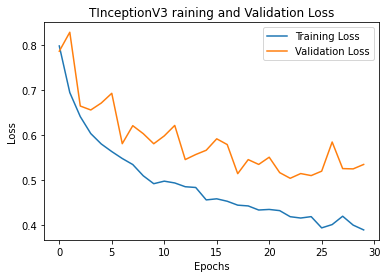

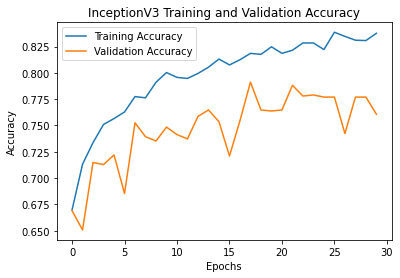

In [20]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('TInceptionV3 raining and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 6s 48ms/step - loss: 0.5350 - acc: 0.7607
Loss: 0.5350479483604431
Accuracy: 0.7606924772262573


In [22]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nInceptionV3 Training classification report:\n", train_class_report)



380/380 [==============================] - 93s 241ms/step

InceptionV3 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20217   0.21393   0.20789      1220
            covid19    0.18930   0.17940   0.18422      1243
             normal    0.20815   0.22753   0.21741      1235
       tuberculosis    0.20567   0.19829   0.20191      1170
    viral_pneumonia    0.20477   0.19142   0.19787      1212

           accuracy                        0.20214      6080
          macro avg    0.20201   0.20212   0.20186      6080
       weighted avg    0.20195   0.20214   0.20184      6080



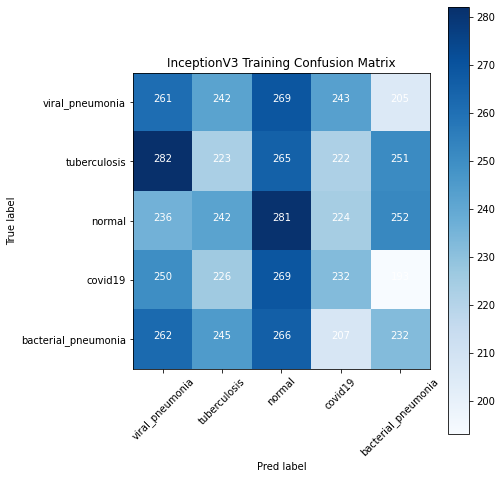

In [23]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("InceptionV3 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()